In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa, torch, torchaudio, joblib
import numpy as np
import scipy.io as sio
from eval_utils import *
import os, pickle
from params import get_arg

/anaconda/envs/pytorch/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
config = get_arg([''])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
data_path = '.'
transfer_f = np.array(pickle.load(open(os.path.join(data_path,'transfer_f.pickle'),'rb')))
transfer_f = torch.from_numpy(transfer_f).to(device)
transfer_f.requires_grad = False
if config.feature in ['wav', 'mel', 'stft']:
    accel_raw_data = joblib.load(open(os.path.join(data_path,'stationary_accel_train.joblib'),'rb'))
    sound_raw_data = joblib.load(open(os.path.join(data_path,'stationary_sound_train.joblib'),'rb'))

In [4]:


def wavToSTFT(config, device=torch.device('cpu')):
    def _wavToSTFT(wav):
        r"""wav (channel, time)"""
        return torch.functional.stft(wav.to(device), n_fft=config.nfft, win_length=config.nfft, hop_length=config.nfft // 2)
    '''output stft (channel, nfft // 2 + 1, time, 2->real,imag)'''
    return _wavToSTFT 

def STFTTowav(config, device=torch.device('cpu')):
    def _STFTTowav(stft):
        '''stft (channel, config.nfft // 2 + 1, time, 2->real,imag)'''
        return torch.functional.istft(stft.to(device), n_fft=config.nfft, win_length=config.nfft, hop_length=config.nfft // 2)
    return _STFTTowav
stft = wavToSTFT(config, device=device)
towav = STFTTowav(config, device)

In [6]:
stft(torch.from_numpy(accel_raw_data[0][:2000]).cpu().transpose(0,1)).shape

torch.Size([12, 65, 32, 2])

In [38]:
st.shape

torch.Size([12, 65, 14653, 2])

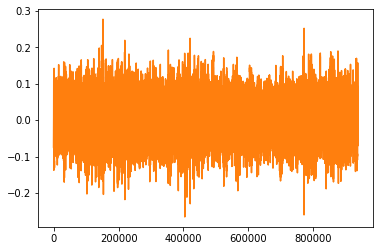

In [23]:
fig = plt.figure()
ax = fig.add_subplot()

ax.plot(accel_raw_data[:0])


st = stft(torch.from_numpy(accel_raw_data[0].transpose(1,0)))
new = towav(st)

ax.plot(new[0].cpu().numpy())

# fig.show()

In [24]:
accel_raw_data[0].shape[0] // (config.nfft // 2) * 

937728

In [31]:
torch.mean(torch.from_numpy(accel_raw_data[0].transpose(1,0))[:,:accel_raw_data[0].shape[0] // (config.nfft // 2) * (config.nfft // 2)] - new.cpu())

tensor(-6.1666e-21, dtype=torch.float64)

In [64]:
def stft_extractor(n_fft=128, win_length=128, hop_length=128//2):
    def _get_stft(x):
        """x should be (time, chan)"""
        time, chan = x.shape
        stft = []
        for i in range(chan):
            _stft = librosa.stft(x[:, i],
                                n_fft=n_fft,
                                win_length=win_length,
                                hop_length=hop_length)
            stft.append(_stft[np.newaxis])
        stft = np.concatenate(stft, axis=0) #(chan, freq, time)
        return stft
    return _get_stft

def istft_extractor(win_length=128, hop_length=128//2):
    def _get_istft(x):
        """x should be (chan, freq, time)"""
        chan, freq, time = x.shape
        stft = []
        for i in range(chan):
            _stft = librosa.istft(x[i, :, :],
                                win_length=win_length,
                                hop_length=hop_length)
            stft.append(_stft[np.newaxis])
        istft = np.concatenate(stft, axis=0) #(chan, freq, time)
        return istft
    return _get_istft

def istft(win_length=128, hop_length=128//2):
    def _get_istft(x):
        # x (chan, freq, time)
        chan, freq, time = x.shape
        return torch.istft(x, n_fft=128)
    return _get_istft

def stft(win_length=128, hop_length=128//2):
    def _get_stft(x):
        # x (chan, time)
        chan, time = x.shape
        return torch.stft(x, n_fft=128)
    return _get_stft

/anaconda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


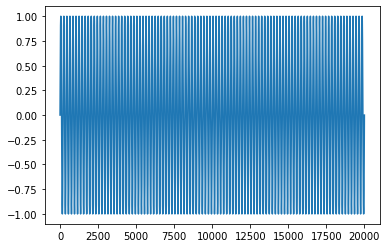

In [65]:
fig = plt.figure()
ax = fig.add_subplot()
data_ = torch.sin(torch.linspace(0, 2*np.pi*100, 200*100)).repeat(8,1)
ax.plot(data_.numpy()[0])
fig.show()

In [69]:
stft()(data_.to('cpu')).shape

torch.Size([8, 65, 626, 2])

In [55]:
istft()(torch.from_numpy(acc_stft))

RuntimeError: istft(CPUComplexFloatType[8, 65, 313], n_fft=128, hop_length=32, win_length=128, window=None, center=1, normalized=0, onesided=1, length=None): expected the last dimension to be 2 (corresponding to real and imaginary parts), but got 313

In [48]:
nfft = 128
win_length = 128
hop_length = win_length // 2
window_fn = torch.hann_window
data = data_.numpy()[:19968]
stft_extract = stft_extractor()

istft_extract = istft_extractor()
acc_stft = stft_extract(data)
acc_istft = istft_extract(acc_stft)

In [45]:
acc_stft

array([[[ 3.2699169e+01+0.0000000e+00j,  4.4136944e+01+0.0000000e+00j,
         -3.7593220e+01+0.0000000e+00j, ...,
          4.6841736e+01+0.0000000e+00j, -7.6233873e+00+0.0000000e+00j,
         -5.8696552e+01+0.0000000e+00j],
        [-7.4178009e+00+1.6653345e-16j, -2.9622160e+01-1.1110140e+01j,
          2.5230392e+01-1.6625134e+01j, ...,
         -3.1437340e+01+7.2842917e+00j,  5.1162691e+00-2.5767624e+01j,
          3.1619278e+01+2.2247756e-01j],
        [-1.1959187e+01+2.3156880e-16j,  6.6884956e+00+3.6462514e+00j,
         -5.6968617e+00+5.4562244e+00j, ...,
          7.0983582e+00-2.3903956e+00j, -1.1551437e+00+8.4568939e+00j,
          1.4887515e-01+2.4606134e-01j],
        ...,
        [-1.5750729e-02+6.5660962e-16j,  3.6772271e-06+6.2970257e-06j,
         -3.9469733e-06+7.5994940e-06j, ...,
         -2.1787933e-05+5.9314181e-05j,  4.5365898e-05+3.6244903e-06j,
         -8.5139191e-03+8.3436258e-04j],
        [ 1.5726283e-02+3.3306691e-16j,  3.3916365e-06+1.8823050e-06j,
    

In [49]:
acc_istft = np.transpose(acc_istft, axes=(1,0))
acc_stft.shape, acc_istft.shape, data.shape

((8, 65, 313), (19968, 8), (19968, 8))

In [39]:
np.sum((acc_istft - data))

7.6327706e-07

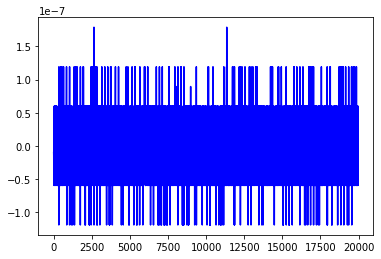

In [43]:
# plt.plot(acc_istft, color='red')
plt.plot(data -acc_istft, color="blue")
# %%

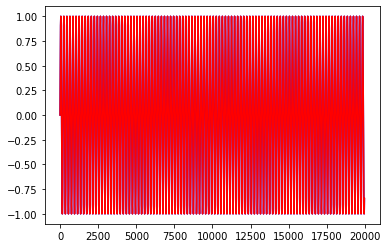

In [41]:
plt.plot(data, color="blue")
plt.plot(acc_istft, color='red')
# %%

In [42]:
acc_stft.imag, acc_stft.real
# %%

(array([[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 1.6653345e-16, -1.1110140e+01, -1.6625134e+01, ...,
           7.2842917e+00, -2.5767624e+01,  2.2247756e-01],
         [ 2.3156880e-16,  3.6462514e+00,  5.4562244e+00, ...,
          -2.3903956e+00,  8.4568939e+00,  2.4606134e-01],
         ...,
         [ 6.5660962e-16,  6.2970257e-06,  7.5994940e-06, ...,
           5.9314181e-05,  3.6244903e-06,  8.3436258e-04],
         [ 3.3306691e-16,  1.8823050e-06,  5.1681122e-06, ...,
          -2.0305862e-04,  4.7389909e-05, -4.2300409e-04],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]], dtype=float32),
 array([[[ 3.2699169e+01,  4.4136944e+01, -3.7593220e+01, ...,
           4.6841736e+01, -7.6233873e+00, -5.8696552e+01],
         [-7.4178009e+00, -2.9622160e+01,  2.5230392e+01, ...,
          -3.1437340e+01,  5.1162691e+00,  3.161927